#Predicting Survival on the Titanic
##History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

## Importing required libraries

In [0]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

### Loading Titanic dataset

In [0]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pclass     1309 non-null   int64 
 1   survived   1309 non-null   int64 
 2   name       1309 non-null   object
 3   sex        1309 non-null   object
 4   age        1309 non-null   object
 5   sibsp      1309 non-null   int64 
 6   parch      1309 non-null   int64 
 7   ticket     1309 non-null   object
 8   fare       1309 non-null   object
 9   cabin      1309 non-null   object
 10  embarked   1309 non-null   object
 11  boat       1309 non-null   object
 12  body       1309 non-null   object
 13  home.dest  1309 non-null   object
dtypes: int64(4), object(10)
memory usage: 143.3+ KB


## Data Cleaning

### Setting missing values to Nan

In [0]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,NaN,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### Keeping only the first entry of the variable 'cabin'

In [0]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22,S,NaN,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### Extracting new variable 'Title' from 'Name'

In [0]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,title
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",Miss
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON",Master
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",Miss
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22,S,NaN,135,"Montreal, PQ / Chesterville, ON",Mr
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",Mrs


### Setting 'age'and 'fare' variable dtypes to float

In [0]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

### Dropping unnecessary data variables  

In [0]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [0]:
# save the data set

data.to_csv('titanic.csv', index=False)

### Setting target, numerical and catergorical variables

In [0]:
target = 'survived'

In [0]:
vars_num = [var for var in data.columns if data[var].dtype  != 'O']

vars_cat = [var for var in data.columns if data[var].dtypes  == 'O']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Identifying variables with missing values

In [0]:
# find missing values first in numerical variables

vars_num_with_na = [
    var for var in vars_num
    if data[var].isnull().sum() > 0 and data[var].dtypes != 'O'
]
vars_num_with_na

['age', 'fare']

In [0]:
# now in categorical variables

vars_cat_with_na = [
    var for var in vars_cat
    if data[var].isnull().sum() > 0 and data[var].dtypes == 'O'
]
vars_cat_with_na

['cabin', 'embarked']

### Checking cardinality of the variables and identifying numerical variables with low cardinality

In [0]:
#Determine cardinality of categorical variables

for var in vars_cat:
  print(var + ' has a cardinality of ' + str(data[var].nunique( )))

sex has a cardinality of 2
cabin has a cardinality of 181
embarked has a cardinality of 3
title has a cardinality of 5


In [0]:
#Determine cardinality of numerical variables

for var in vars_num:
  print(var + ' has a cardinality of ' + str(data[var].nunique( )))

pclass has a cardinality of 3
survived has a cardinality of 2
age has a cardinality of 98
sibsp has a cardinality of 7
parch has a cardinality of 8
fare has a cardinality of 281


In [0]:
discrete_vars = [var for var in vars_num if data[var].nunique() < 10]
discrete_vars

['pclass', 'survived', 'sibsp', 'parch']

In [0]:
cont_vars = [var for var in vars_num if var not in discrete_vars]
cont_vars

['age', 'fare']

### Analysing distributions of numerical variables with high cardinality

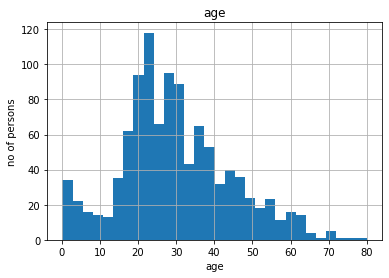

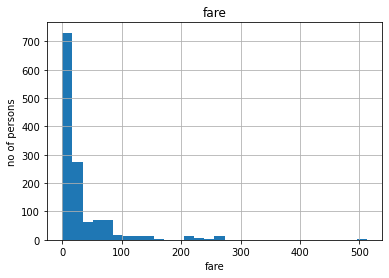

In [0]:
# Let's go ahead and analyse the distributions of these variables


def analyse_continuous(df, var):
    df = df.copy()
    df[var].hist(bins=30)
    plt.ylabel('no of persons')
    plt.xlabel(var)
    plt.title(var)
    plt.show()


for var in cont_vars:
    analyse_continuous(data, var)

### Splitting datset into train and test

In [0]:
# Splitting dataset into test and train data
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

In [0]:
# Resetting index values for target variable
y_train= y_train.reset_index(drop=True)
y_test= y_test.reset_index(drop=True)
y_train.head()

0    0
1    1
2    0
3    0
4    0
Name: survived, dtype: int64

In [0]:
X_train= X_train.reset_index(drop=True)
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
0,3,male,25.0,0,0,7.9250,Rare,S,Mr,0,0
1,1,female,41.0,0,0,134.5000,Rare,C,Miss,0,0
2,3,male,28.0,0,0,7.7333,Rare,Q,Mr,1,0
3,3,female,18.0,0,0,7.7750,Rare,S,Miss,0,0
4,2,male,29.0,1,0,21.0000,Rare,S,Mr,0,0


In [0]:
X_test= X_test.reset_index(drop=True)
X_test.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
0,3,male,38.0,0,0,7.8958,Rare,S,Mr,0,0
1,2,female,21.0,0,1,21.0000,Rare,S,Miss,0,0
2,2,male,42.0,1,0,27.0000,Rare,S,Mr,0,0
3,3,male,28.0,0,0,14.5000,Rare,S,Mr,1,0
4,2,male,25.0,0,0,31.5000,Rare,S,Mr,0,0


### Selecting only the first letter for the 'cabin'

In [0]:
#Extract only the letter (and drop the number) from the variable Cabin
def split(word): 
    return [char for char in word] 

In [0]:
# Cabin split in train set
cabin = []
for var in X_train['cabin']:
  if type(var) == str:
    cabin.append(split(var)[0])
  else:
    cabin.append(var)
X_train['cabin'] = cabin

In [0]:
# Cabin split in test set
cabin = []
for var in X_test['cabin']:
  if type(var) == str:
    cabin.append(split(var)[0])
  else:
    cabin.append(var)
X_test['cabin'] = cabin

### Dealing with numerical and catergorical missing values

In [0]:
X_train[vars_num_with_na].isnull().sum()

age     206
fare      1
dtype: int64

In [0]:
# replace engineer missing values as we described above

for var in vars_num_with_na:

    # calculate the mode using the train set
    median_val = X_train[var].median()

    # add binary missing indicator (in train and test)
    X_train[var+'_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the mode
    # (in train and test)
    X_train[var] = X_train[var].fillna(median_val)
    X_test[var] = X_test[var].fillna(median_val)

# check that we have no more missing values in the engineered variables
X_train[vars_num_with_na].isnull().sum()

age     0
fare    0
dtype: int64

In [0]:
# for catergorical variables

X_train[vars_cat_with_na] = X_train[vars_cat_with_na].fillna('Missing')
X_test[vars_cat_with_na] = X_test[vars_cat_with_na].fillna('Missing')

In [0]:
X_train[vars_cat_with_na].isnull().sum()

cabin       0
embarked    0
dtype: int64

### Identifying and categorizing rare labels

In [0]:
# Dealing with rare labels
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the survived persons in the dataset

    df = df.copy()

    tmp = df.groupby(var)['fare'].count() / len(df)

    return tmp[tmp > rare_perc].index


for var in vars_cat:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

In [0]:
X_train.head(20)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1118,3,male,25.0,0,0,7.9250,Rare,S,Mr,0,0
44,1,female,41.0,0,0,134.5000,Rare,C,Miss,0,0
1072,3,male,28.0,0,0,7.7333,Rare,Q,Mr,1,0
1130,3,female,18.0,0,0,7.7750,Rare,S,Miss,0,0
574,2,male,29.0,1,0,21.0000,Rare,S,Mr,0,0
1217,3,male,19.0,0,0,7.6500,Rare,S,Mr,0,0
500,2,male,46.0,0,0,26.0000,Rare,S,Mr,0,0
958,3,female,28.0,0,4,25.4667,Rare,S,Mrs,1,0
269,1,male,28.0,0,0,26.0000,Rare,S,Mr,1,0
322,1,female,36.0,0,0,135.6333,C,C,Miss,0,0


In [0]:
X_test['cabin'].unique()

array(['Rare', 'C'], dtype=object)

### One hot encoding on catergorical variables

In [0]:
X_train[vars_cat].head()

,sex,cabin,embarked,title
1118,male,Rare,S,Mr
44,female,Rare,C,Miss
1072,male,Rare,Q,Mr
1130,female,Rare,S,Miss
574,male,Rare,S,Mr


In [0]:
len(X_train)

1047

In [0]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

# 2. FIT
enc.fit(X_train[vars_cat])

# 3. Transform
onehotlabels = enc.transform(X_train[vars_cat]).toarray()
onehotlabels.shape


(1047, 12)

In [0]:
enc.categories_

[array(['female', 'male'], dtype=object),
 array(['C', 'Rare'], dtype=object),
 array(['C', 'Q', 'Rare', 'S'], dtype=object),
 array(['Miss', 'Mr', 'Mrs', 'Rare'], dtype=object)]

In [0]:
columns = []
k=0
for var in vars_cat:
  if k < len(enc.categories_):
    for i in range(len(enc.categories_[k])):
      column =[var + "_" + str(enc.categories_[k][i])]
      columns.append(column)
    k += 1
columns = [item for sublist in columns for item in sublist]
columns

['sex_female',
 'sex_male',
 'cabin_C',
 'cabin_Rare',
 'embarked_C',
 'embarked_Q',
 'embarked_Rare',
 'embarked_S',
 'title_Miss',
 'title_Mr',
 'title_Mrs',
 'title_Rare']

In [0]:
dfOneHot = pd.DataFrame(onehotlabels, columns =columns)
len(dfOneHot)

1047

In [0]:
dfOneHot.head(10)

,sex_female,sex_male,cabin_C,cabin_Rare,embarked_C,embarked_Q,embarked_Rare,embarked_S,title_Miss,title_Mr,title_Mrs,title_Rare
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
9,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [0]:
X_train = pd.concat([X_train, dfOneHot], axis=1)
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na,sex_female,sex_male,cabin_C,cabin_Rare,embarked_C,embarked_Q,embarked_Rare,embarked_S,title_Miss,title_Mr,title_Mrs,title_Rare
0,3,male,25.0,0,0,7.9250,Rare,S,Mr,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1,female,41.0,0,0,134.5000,Rare,C,Miss,0,0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,male,28.0,0,0,7.7333,Rare,Q,Mr,1,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,female,18.0,0,0,7.7750,Rare,S,Miss,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,2,male,29.0,1,0,21.0000,Rare,S,Mr,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [0]:
#Test_set
ent = OneHotEncoder()
ent.fit(X_test[vars_cat])

# 3. Transform
onehotlabel = ent.transform(X_test[vars_cat]).toarray()
onehotlabel.shape

(262, 11)

In [0]:
ent.categories_

[array(['female', 'male'], dtype=object),
 array(['C', 'Rare'], dtype=object),
 array(['C', 'Q', 'S'], dtype=object),
 array(['Miss', 'Mr', 'Mrs', 'Rare'], dtype=object)]

In [0]:
columns = []
k=0
for var in vars_cat:
  if k < len(ent.categories_):
    for i in range(len(ent.categories_[k])):
      column =[var + "_" + str(ent.categories_[k][i])]
      columns.append(column)
    k += 1
columns = [item for sublist in columns for item in sublist]
columns

['sex_female',
 'sex_male',
 'cabin_C',
 'cabin_Rare',
 'embarked_C',
 'embarked_Q',
 'embarked_S',
 'title_Miss',
 'title_Mr',
 'title_Mrs',
 'title_Rare']

In [0]:
dfOneHott = pd.DataFrame(onehotlabel, columns =columns)

In [0]:
X_test = pd.concat([X_test, dfOneHott], axis=1)
X_test.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na,sex_female,sex_male,cabin_C,cabin_Rare,embarked_C,embarked_Q,embarked_S,title_Miss,title_Mr,title_Mrs,title_Rare
0,3,male,38.0,0,0,7.8958,Rare,S,Mr,0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2,female,21.0,0,1,21.0000,Rare,S,Miss,0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,2,male,42.0,1,0,27.0000,Rare,S,Mr,0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,3,male,28.0,0,0,14.5000,Rare,S,Mr,1,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,2,male,25.0,0,0,31.5000,Rare,S,Mr,0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [0]:
X_test.drop(labels=vars_cat, axis = 1, inplace = True)
X_train.drop(labels = vars_cat, axis = 1, inplace = True)

In [0]:
X_train.drop(labels = ['embarked_Rare'], axis = 1, inplace = True)

In [0]:
X_train.head(10)

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_female,sex_male,cabin_C,cabin_Rare,embarked_C,embarked_Q,embarked_S,title_Miss,title_Mr,title_Mrs,title_Rare
0,3,25.0,0,0,7.9250,0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1,41.0,0,0,134.5000,0,0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,28.0,0,0,7.7333,1,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,3,18.0,0,0,7.7750,0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,2,29.0,1,0,21.0000,0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5,3,19.0,0,0,7.6500,0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6,2,46.0,0,0,26.0000,0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7,3,28.0,0,4,25.4667,1,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8,1,28.0,0,0,26.0000,1,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
9,1,36.0,0,0,135.6333,0,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


### Feature Scaling

In [0]:
# Feature scaling

# capture all variables in a list
# except the target and the ID

train_vars = [var for var in X_train.columns]
# count number of variables
len(train_vars)

18

In [0]:
# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X_train[train_vars]) 

# transform the train and test set
X_train[train_vars] = scaler.transform(X_train[train_vars])

X_test[train_vars] = scaler.transform(X_test[train_vars])

In [0]:
X_train.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_female,sex_male,cabin_C,cabin_Rare,embarked_C,embarked_Q,embarked_S,title_Miss,title_Mr,title_Mrs,title_Rare
0,0.835808,-0.370162,-0.478911,-0.455423,-0.504782,-0.494921,-0.03092,-0.761042,0.761042,-0.283717,0.283717,-0.493425,-0.319539,0.639650,-0.500895,0.869892,-0.435629,-0.275778
1,-1.542157,0.904029,-0.478911,-0.455423,1.971555,-0.494921,-0.03092,1.313987,-1.313987,-0.283717,0.283717,2.026652,-0.319539,-1.563355,1.996425,-1.149569,-0.435629,-0.275778
2,0.835808,-0.131251,-0.478911,-0.455423,-0.508533,2.020526,-0.03092,-0.761042,0.761042,-0.283717,0.283717,-0.493425,3.129507,-1.563355,-0.500895,0.869892,-0.435629,-0.275778
3,0.835808,-0.927621,-0.478911,-0.455423,-0.507717,-0.494921,-0.03092,1.313987,-1.313987,-0.283717,0.283717,-0.493425,-0.319539,0.639650,1.996425,-1.149569,-0.435629,-0.275778
4,-0.353174,-0.051614,0.434422,-0.455423,-0.248980,-0.494921,-0.03092,-0.761042,0.761042,-0.283717,0.283717,-0.493425,-0.319539,0.639650,-0.500895,0.869892,-0.435629,-0.275778


In [0]:
X_train.to_csv('xtrain.csv', index=False)
X_test.to_csv('xtest.csv', index=False)

### Model training/Performance Evaluation

In [0]:
# Model Building

# set up the model
# remember to set the random_state / seed

logisticRegr = LogisticRegression(C =0.0005, random_state=0)

# train the model

logisticRegr.fit(X_train, y_train)

LogisticRegression(C=0.0005, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Making predictions and evaluation metrics

y_pred = logisticRegr.predict(X_test)

accuracy_score(y_test, y_pred, normalize=False)

191

In [0]:
# get probabilties
lr_probs = logisticRegr.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

# get auc score
lr_auc = roc_auc_score(y_test, lr_probs)

In [0]:
print(lr_auc)

0.8350925925925925
